In [1]:
import os
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import pacmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

### Load Samples & FlowJo 10 workspace

In [2]:
base_dir = "data/8_color_data_set/"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

seed = 123

In [3]:
session = fk.Session(sample_path)
session.import_flowjo_workspace(wsp_path)

In [4]:
sample_groups = session.get_sample_groups()
sample_groups

['default', 'All Samples', 'DEN']

In [5]:
sample_group = sample_groups[-1]

In [6]:
print(session.get_gate_hierarchy(sample_group, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


In [7]:
sample_ids = session.get_sample_ids()
sample_ids

['101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

### Run analyze_samples & retrieve gated events as DataFrames

In [8]:
session.analyze_samples(sample_group)

In [9]:
dfs = session.get_wsp_gated_events(sample_group, gate_id="Singlets")

In [10]:
dfs[0].head()

,sample_group,sample_id,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A,Time
1,DEN,101_DEN084Y5_15_E03_009_clean.fcs,0.484332,0.397831,0.304358,0.178974,0.165913,0.269681,0.242188,0.230791,0.282167,0.254901,0.244743,0.454572,0.276832,0.610560,0.029446
2,DEN,101_DEN084Y5_15_E03_009_clean.fcs,0.194679,0.158451,0.307160,0.169375,0.163517,0.258956,0.245903,0.312879,0.337170,0.338146,0.255419,0.219998,0.509837,0.231417,0.029487
3,DEN,101_DEN084Y5_15_E03_009_clean.fcs,0.474315,0.371048,0.319578,0.117765,0.111023,0.265181,0.246087,0.334186,0.286235,0.240530,0.239981,0.227485,0.293971,0.225222,0.029501
4,DEN,101_DEN084Y5_15_E03_009_clean.fcs,0.379263,0.326553,0.290353,0.253630,0.230423,0.275179,0.254722,0.293769,0.300224,0.253962,0.231450,0.571648,0.275452,0.327632,0.029584
5,DEN,101_DEN084Y5_15_E03_009_clean.fcs,0.571001,0.413601,0.345140,0.375197,0.322048,0.291258,0.606901,0.316733,0.331642,0.291612,0.266619,0.280217,0.380370,0.285660,0.029625


In [11]:
k = 10_000
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

In [12]:
X.head()

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A
253480,0.402326,0.308075,0.326484,0.166460,0.154160,0.269948,0.254796,0.267836,0.368446,0.236508,0.233974,0.514631,0.256705,0.629362
124273,0.594558,0.478321,0.310753,0.205795,0.186924,0.275238,0.263040,0.688992,0.300224,0.262380,0.244585,0.397435,0.298307,0.284815
256992,0.550725,0.447937,0.307368,0.168647,0.160904,0.262031,0.255615,0.627383,0.281032,0.256775,0.259832,0.500045,0.363527,0.308397
254010,0.355311,0.310299,0.286265,0.109438,0.106258,0.257481,0.248407,0.466122,0.298910,0.296931,0.217400,0.394378,0.289422,0.286191
258159,0.411198,0.338459,0.303728,0.216016,0.195560,0.276150,0.240899,0.479502,0.274638,0.249732,0.260403,0.227955,0.277606,0.238232


### Perform Louvain & Leiden clustering

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
communities_louvain, graph_louvain, Q_louvain = phenograph.cluster(
    X_scaled, 
    clustering_algo='louvain', 
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.299047470092773 seconds
Jaccard graph constructed in 2.0446581840515137 seconds
Wrote graph to binary file in 0.5693659782409668 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.856835
After 6 runs, maximum modularity is Q = 0.858209
Louvain completed 26 runs in 35.756389141082764 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 47.0578031539917 seconds


In [15]:
communities_leiden, graph_leiden, Q_leiden = phenograph.cluster(
    X_scaled, 
    clustering_algo='leiden',
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.3086576461792 seconds
Jaccard graph constructed in 1.935607671737671 seconds
Running Leiden optimization
Leiden completed in 4.608449459075928 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.07190990447998 seconds


In [16]:
titles = ['Leiden', 'Louvain']
communities = [communities_leiden, communities_louvain]

In [17]:
leiden_means = [
    X_scaled[communities_leiden==i, :].mean(axis=0)
    for i in np.unique(communities_leiden)
]
leiden_clusters = pd.DataFrame(
    leiden_means, 
    columns = X.columns, 
    index=np.unique(communities_leiden)
)
leiden_clusters.index.name = 'Cluster'

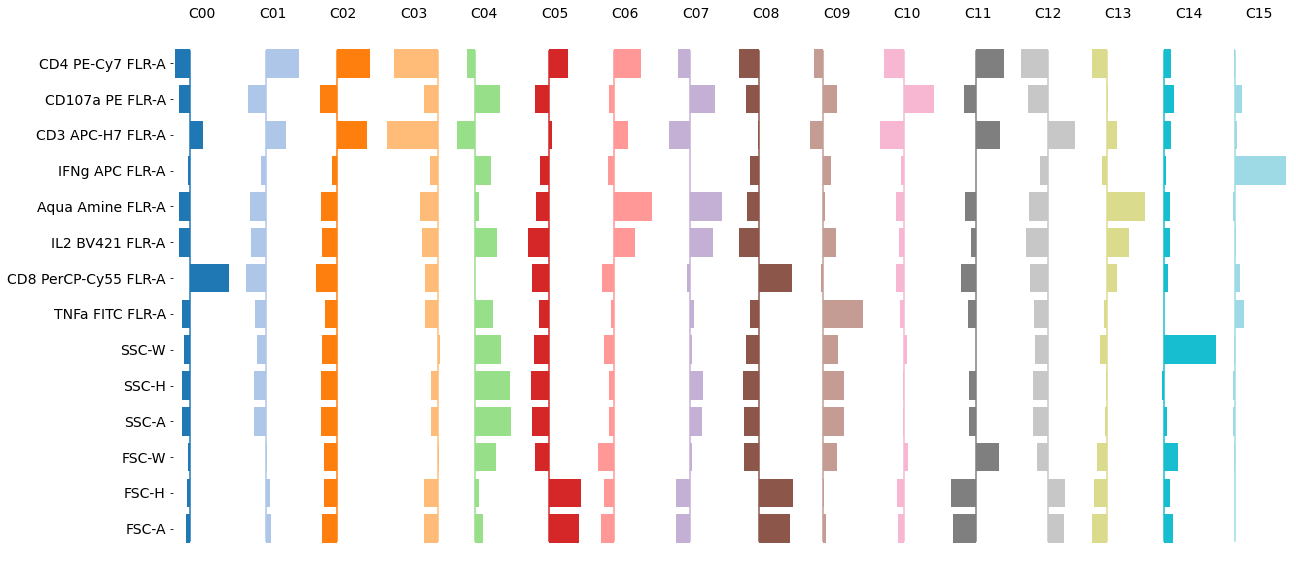

In [18]:
tab20 = plt.cm.get_cmap('tab20')
n, p = leiden_clusters.shape

fig, axes = plt.subplots(1, n, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    ax.barh(range(p), leiden_clusters.iloc[i,:], color=tab20(int(i*(20+1)/n)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'C{i:02d}', fontsize=14)
    ax.axvline(0, c=tab20(int(i*(20+1)/n)), ymin=0.05, ymax=0.95)
    
    if i == 0:
        ax.set_yticks(range(p))
        ax.set_yticklabels(leiden_clusters.columns,fontsize=14)

### Apply dimension reduction using PaCMAP

In [19]:
embedder = pacmap.PaCMAP()

In [20]:
X2 = embedder.fit_transform(X_scaled)

In [21]:
min_max_scaler = MinMaxScaler()
X2 = min_max_scaler.fit_transform(X2)

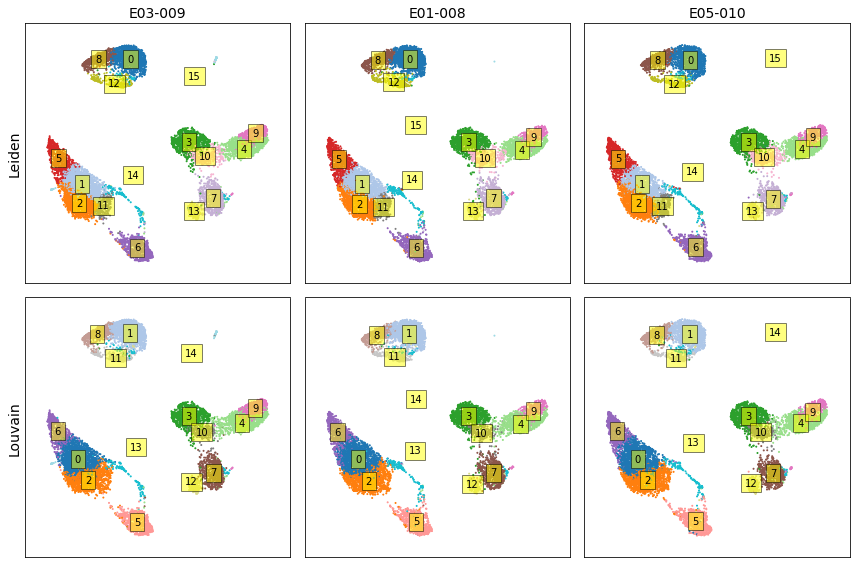

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (community, title) in enumerate(zip(communities, titles)):
    for j in range(3):
        z = community[(j*k):(j+1)*k]
        x = X2[(j*k):(j+1)*k, 0]
        y = X2[(j*k):(j+1)*k, 1]
        
        ax = axes[i, j]
        ax.scatter(x, y, s=1, c=z, cmap='tab20')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
        if j==0:
            ax.set_ylabel(title, fontsize=14)
        if i==0:
            ax.set_title('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
            
        for idx in np.unique(z):
            x_, y_ = x[z==idx], y[z==idx]
            x_c, y_c = np.mean(x_), np.mean(y_)
            
            ax.text(
                x_c, 
                y_c, 
                str(idx), 
                va='center', 
                ha='center', 
                bbox=dict(fc='yellow', alpha=0.5)
            )
            
plt.tight_layout()